In [2]:
# Gerekli kütüphaneleri içe aktaralım
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import datetime
import warnings
import os
import time

# Matplotlib ve seaborn ayarlarını yapalım
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Matplotlib figürlerinin boyutunu ayarlayalım
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12


In [3]:
data_path = '../data/pepe-transfers.csv'

In [4]:
sample_df = pd.read_csv(data_path, nrows=5)
print("Sample:")
sample_df.head()

Sample:


,block_number,timestamp,date,from_address,to_address,value_token,value_base,transaction_index,log_index,transaction_hash
0,17050363,1681536587,2023-Apr-15T07:29:47Z,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,6.044788e+11,604478780314562436526661163632,59,162,0xc321dac6609df6c3baf3512be31a967d93397a79c597...
1,17050354,1681536479,2023-Apr-15T07:27:59Z,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,1.311359e+11,131135861213042893154914604963,70,287,0xb745bfba489c1abe20a5fbc72a655fa5ba18ded2ce84...
2,17050352,1681536455,2023-Apr-15T07:27:35Z,0x4a5a7331da84d3834c030a9b8d4f3d687a3b788b,0x4a5a7331da84d3834c030a9b8d4f3d687a3b788b,3.717649e+11,371764915766751234543927965993,115,262,0x2036f8a047ca64006862e99049150f14ccacfb4e3a73...
3,17050352,1681536455,2023-Apr-15T07:27:35Z,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,3.717649e+11,371764915766751234543927965993,115,257,0x2036f8a047ca64006862e99049150f14ccacfb4e3a73...
4,17050350,1681536431,2023-Apr-15T07:27:11Z,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,7.920714e+10,79207141801681976718549271230,126,323,0x0ae21fcaf097b54cc2049777df2018e65822eea74709...


In [5]:
df = pd.read_csv(data_path)
print("Missing values per column:")
df.isna().sum()

# %% [markdown]
# Now let's convert the timestamp to a proper datetime format and explore the date range of our dataset.

# %%
# Convert timestamp to datetime
df['date'] = pd.to_datetime(df['date'])

# Check time range
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")

print("Types:")
sample_df.dtypes

Missing values per column:
Date range: 2023-04-14 16:51:35+00:00 to 2023-05-08 10:26:35+00:00
Total days: 23
Types:


block_number           int64
timestamp              int64
date                  object
from_address          object
to_address            object
value_token          float64
value_base            object
transaction_index      int64
log_index              int64
transaction_hash      object
dtype: object

In [6]:
# %%
# Check for missing values

df = pd.read_csv(data_path)
print("Missing values per column:")
df.isna().sum()

# %% [markdown]
# Now let's convert the timestamp to a proper datetime format and explore the date range of our dataset.

# %%
# Convert timestamp to datetime
df['date'] = pd.to_datetime(df['date'])

# Check time range
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")

Missing values per column:
Date range: 2023-04-14 16:51:35+00:00 to 2023-05-08 10:26:35+00:00
Total days: 23


Token transfer statistics:


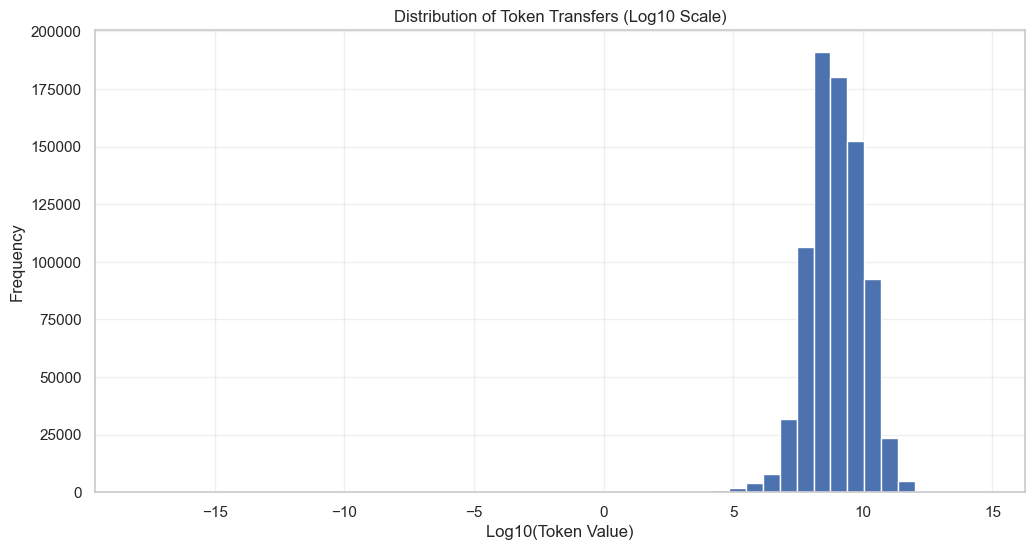

In [7]:
# Basic statistics of token transfers
print("Token transfer statistics:")
df['value_token'].describe()

# %% [markdown]
# Let's check the distribution of token values to understand the transfer patterns.

# %%
# Plot histogram of token values (log scale)
plt.figure(figsize=(12, 6))
df['value_token'].apply(lambda x: np.log10(x) if x > 0 else 0).hist(bins=50)
plt.title('Distribution of Token Transfers (Log10 Scale)')
plt.xlabel('Log10(Token Value)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
df.describe()

,block_number,timestamp,value_token,transaction_index,log_index
count,8.009550e+05,8.009550e+05,8.009550e+05,800955.000000,800955.000000
mean,1.714966e+07,1.682746e+09,1.318891e+10,80.442673,202.735466
std,4.676130e+04,5.680853e+05,6.634689e+11,60.132155,138.733431
min,1.704610e+07,1.681484e+09,0.000000e+00,0.000000,0.000000
25%,1.710312e+07,1.682181e+09,1.873315e+08,31.000000,101.000000
50%,1.716388e+07,1.682919e+09,8.590582e+08,79.000000,192.000000
75%,1.719161e+07,1.683255e+09,5.337008e+09,115.000000,281.000000
max,1.721458e+07,1.683534e+09,4.206900e+14,1016.000000,6923.000000


In [25]:
# %%
print("🔧 Building the network...")

# Create a directed graph
G = nx.DiGraph()

# Optional: add all unique nodes first (not strictly necessary)
# You can skip this if you're adding edges anyway
# G.add_nodes_from(pd.concat([df['from_address'], df['to_address']]).unique())

# Choose mode: 'weighted' or 'unweighted'
USE_WEIGHTS = True

if USE_WEIGHTS:
    print("→ Using weighted edges based on value_token")
    edge_weights = {}

    for _, row in df.iterrows():
        from_addr = row['from_address']
        to_addr = row['to_address']
        value = row['value_token']

        key = (from_addr, to_addr)
        edge_weights[key] = edge_weights.get(key, 0) + value

    for (from_addr, to_addr), weight in edge_weights.items():
        G.add_edge(from_addr, to_addr, weight=weight)

else:
    print("→ Using unweighted edges (multiple transfers count toward degree)")
    for _, row in df.iterrows():
        from_addr = row['from_address']
        to_addr = row['to_address']
        G.add_edge(from_addr, to_addr)

print(f"✅ Added {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

🔧 Building the network...
→ Using weighted edges based on value_token
✅ Added 88821 nodes and 88821 edges


In [26]:
# %%
# Basic network statistics
print("Network Summary:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.6f}")

Network Summary:
Number of nodes: 88821
Number of edges: 88821
Network density: 0.000011


In [27]:
# Check if the graph is connected
# For directed graphs, we should check strongly and weakly connected components
scc = list(nx.strongly_connected_components(G))
wcc = list(nx.weakly_connected_components(G))
print(f"Number of strongly connected components: {len(scc)}")
print(f"Size of largest strongly connected component: {len(max(scc, key=len))}")
print(f"Number of weakly connected components: {len(wcc)}")
print(f"Size of largest weakly connected component: {len(max(wcc, key=len))}")

Number of strongly connected components: 88821
Size of largest strongly connected component: 1
Number of weakly connected components: 88821
Size of largest weakly connected component: 1


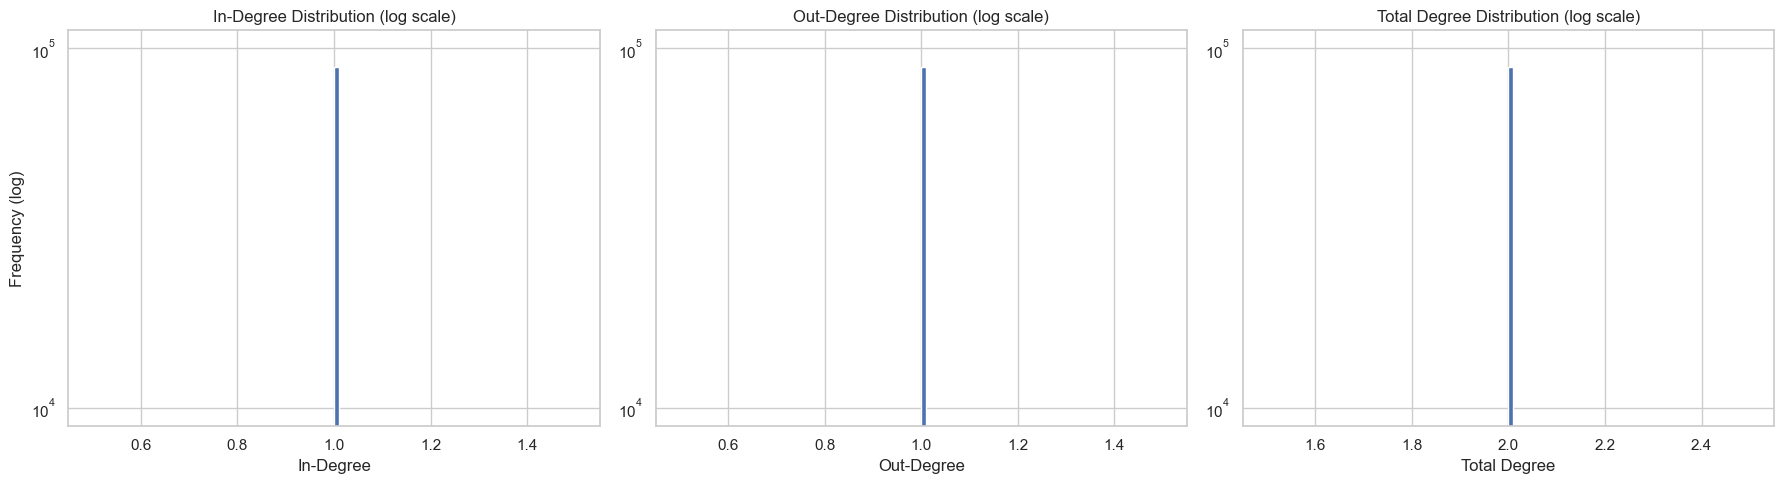

In [28]:
# Activate inline plotting for Jupyter (important!)
%matplotlib inline

# Calculate degrees
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = {node: in_degrees.get(node, 0) + out_degrees.get(node, 0) for node in G.nodes()}

# Extract degree values
in_vals = list(in_degrees.values())
out_vals = list(out_degrees.values())
total_vals = list(total_degrees.values())

# Set plot style
sns.set(style="whitegrid")

# Plot log-log degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot in-degree
axes[0].hist(in_vals, bins=100, log=True)
axes[0].set_title("In-Degree Distribution (log scale)")
axes[0].set_xlabel("In-Degree")
axes[0].set_ylabel("Frequency (log)")

# Plot out-degree
axes[1].hist(out_vals, bins=100, log=True)
axes[1].set_title("Out-Degree Distribution (log scale)")
axes[1].set_xlabel("Out-Degree")

# Plot total degree
axes[2].hist(total_vals, bins=100, log=True)
axes[2].set_title("Total Degree Distribution (log scale)")
axes[2].set_xlabel("Total Degree")

plt.tight_layout()
plt.show()


In [29]:
# Function to compute CCDF (Complementary Cumulative Distribution Function)
def ccdf(data):
    counter = Counter(data)
    probs = {}
    for k, v in counter.items():
        probs[k] = v / len(data)

    # Sort unique values
    unique_values = sorted(probs.keys())

    # Calculate CCDF
    ccdf_values = []
    cumulative = 0
    for value in unique_values:
        cumulative += probs[value]
        ccdf_values.append(1 - cumulative)

    return unique_values, ccdf_values

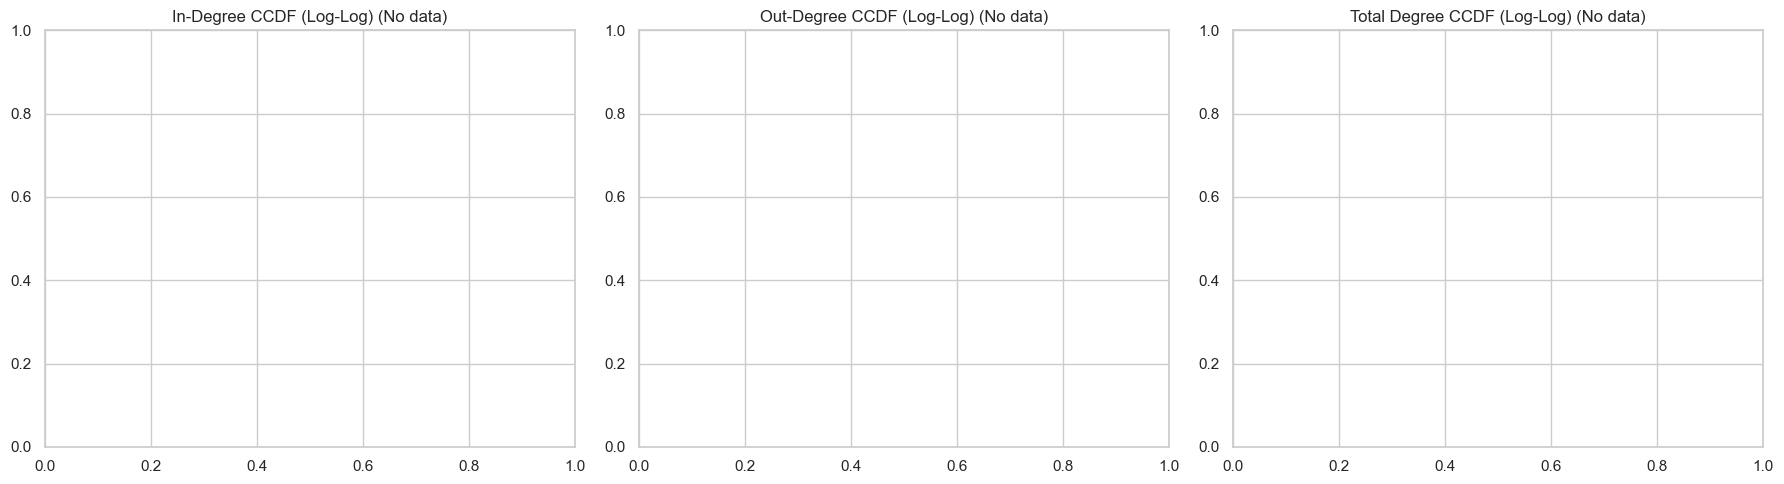

In [30]:
def safe_ccdf_plot(ax, data, title, xlabel):
    x, y = ccdf(data)
    filtered = [(xi, yi) for xi, yi in zip(x, y) if xi > 0 and yi > 0]
    
    if not filtered:
        ax.set_title(f"{title} (No data)")
        return
    
    x_filtered, y_filtered = zip(*filtered)
    ax.loglog(x_filtered, y_filtered, 'o-', markersize=3, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CCDF')
    ax.grid(True, which="both", ls="-", alpha=0.2)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

safe_ccdf_plot(axes[0], in_degree_values, "In-Degree CCDF (Log-Log)", "In-Degree")
safe_ccdf_plot(axes[1], out_degree_values, "Out-Degree CCDF (Log-Log)", "Out-Degree")
safe_ccdf_plot(axes[2], total_degree_values, "Total Degree CCDF (Log-Log)", "Total Degree")

plt.tight_layout()
plt.show()


In [31]:
df["from_address"].value_counts().head()
df["to_address"].value_counts().head()


to_address
0xa43fe16908251ee70ef74718545e4fe6c5ccec9f    159319
0x11950d141ecb863f01007add7d1a342041227b58    129394
0x74de5d4fcbf63e00296fd95d33236b9794016631     75357
0xf239009a101b6b930a527deaab6961b6e7dec8a6     63499
0xe66b31678d6c16e9ebf358268a790b763c133750     14345
Name: count, dtype: int64